In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

import datetime

In [35]:
data = pd.read_csv('dataset/SamsumgStock.KS.csv')
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
723,2020-09-09,58200,59300,57800,58400,58400.0,30597399
724,2020-09-10,59900,60000,59100,59200,59200.0,29923293
725,2020-09-11,59300,59400,58200,59000,59000.0,16017098
726,2020-09-14,60200,60800,59900,60400,60400.0,20648281
727,2020-09-15,60900,61000,60500,61000,61000.0,17787753


## Compute Mid Price

In [36]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2
len(mid_prices)
print(mid_prices)
print(max(mid_prices), min(mid_prices))
max_price = max(mid_prices)
min_price = min(mid_prices)

[50210. 51500. 52210. 52170. 52590. 53340. 53620. 51850. 51860. 51230.
 53220. 54050. 54630. 54310. 54310. 54690. 54640. 53840. 53450. 54320.
 54410. 54060. 53150. 52730. 54010. 54470. 56840. 57140. 56500. 55920.
 56390. 56460. 56410. 56160. 56450. 56330. 55820. 56350. 55590. 55560.
 55910. 55340. 54000. 52500. 52870. 51030. 51290. 50680. 50790. 50790.
 50500. 51520. 51770. 51880. 51600. 51670. 51000. 50930. 51800. 50080.
 49600. 49150. 49010. 50230. 51990. 51410. 51660. 52010. 50850. 49580.
 48640. 47620. 48450. 49380. 49540. 50230. 49710. 48320. 48730. 49130.
 49760. 50310. 51190. 50210. 51870. 50340. 48550. 47160. 47250. 47030.
 46300. 44800. 45680. 47130. 48520. 48830. 47690. 47210. 47010. 47280.
 47320. 47880. 47550. 46400. 45620. 46460. 48060. 48780. 49890. 50180.
 51010. 51500. 51520. 50830. 50890. 50650. 51420. 51410. 50160. 49660.
 49770. 48720. 48940. 49490. 48860. 47710. 47590. 48360. 47990. 48820.
 48630. 49250. 49160. 49790. 50230. 50180. 50970. 52260. 51840. 51540.
 50970

## Create Windows

Window: 50  
최근 50일 데이터를 보고 다음을 예측한다.

In [39]:
seq_len = 100
output_len = 5
sequence_length = seq_len + output_len

result = []

for index in range(len(mid_prices)):
    if  len(mid_prices) <= (index * output_len) + sequence_length:
        break
    result.append(mid_prices[(index * output_len) : (index * output_len) + sequence_length])


# for index in range(len(mid_prices) - sequence_length + 5):
#     result.append(mid_prices[index: index + sequence_length]) # slicing 60개

In [41]:
print(result)
print(len(result))

[array([50210., 51500., 52210., 52170., 52590., 53340., 53620., 51850.,
       51860., 51230., 53220., 54050., 54630., 54310., 54310., 54690.,
       54640., 53840., 53450., 54320., 54410., 54060., 53150., 52730.,
       54010., 54470., 56840., 57140., 56500., 55920., 56390., 56460.,
       56410., 56160., 56450., 56330., 55820., 56350., 55590., 55560.,
       55910., 55340., 54000., 52500., 52870., 51030., 51290., 50680.,
       50790., 50790., 50500., 51520., 51770., 51880., 51600., 51670.,
       51000., 50930., 51800., 50080., 49600., 49150., 49010., 50230.,
       51990., 51410., 51660., 52010., 50850., 49580., 48640., 47620.,
       48450., 49380., 49540., 50230., 49710., 48320., 48730., 49130.,
       49760., 50310., 51190., 50210., 51870., 50340., 48550., 47160.,
       47250., 47030., 46300., 44800., 45680., 47130., 48520., 48830.,
       47690., 47210., 47010., 47280., 47320., 47880., 47550., 46400.,
       45620.]), array([53340., 53620., 51850., 51860., 51230., 53220., 5405

## Normalize Data

모델이 잘 예측하게 함. 

### How?

(맨 처음 값 - 해당 값) - 1 -> -1 해주는 이유는 처음 값을 0 으로 만들기 위함

In [42]:
normalized_data = []

for window in result:
    normalized_window = [(float(p) - min_price) / (max_price + min_price) for p in window]
    normalized_data.append(normalized_window)
result = np.array(normalized_data)
result = np.array(result)
result.shape

(125, 105)

In [43]:
# split train and test data

train = result[ :-2, : ]

np.random.shuffle(train)

row = int(round(train.shape[0] * 0.9))
x_train = train[:row, :100]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:row, 100:]

x_valid = train[row:, :100]
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
y_valid = train[row:, 100:]

x_test = result[-2:, :100]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[-2:, 100:]

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(111, 100, 1) (111, 5)
(12, 100, 1) (12, 5)
(2, 100, 1) (2, 5)


 ## Build a Model

In [44]:
model = Sequential()

model.add(LSTM(150, return_sequences=True, input_shape=(100, 1)))

model.add(LSTM(250, return_sequences=False))

model.add(Dense(5, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop', metrics='accuracy')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100, 150)          91200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 250)               401000    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1255      
Total params: 493,455
Trainable params: 493,455
Non-trainable params: 0
_________________________________________________________________


In [45]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
filename = 'tmp_checkpoint.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

earlystopping = EarlyStopping(monitor='val_loss', patience=50)

## Training

In [46]:
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=20, epochs=400, 
          callbacks=[checkpoint])

Epoch 1/400
5/6 [========================>.....] - ETA: 0s - loss: 0.0534 - accuracy: 0.1800
Epoch 00001: val_loss improved from inf to 0.00849, saving model to tmp_checkpoint.h5
6/6 [==============================] - 1s 129ms/step - loss: 0.0488 - accuracy: 0.1712 - val_loss: 0.0085 - val_accuracy: 0.2500
Epoch 2/400
5/6 [========================>.....] - ETA: 0s - loss: 0.0037 - accuracy: 0.2500
Epoch 00002: val_loss improved from 0.00849 to 0.00219, saving model to tmp_checkpoint.h5
6/6 [==============================] - 0s 22ms/step - loss: 0.0034 - accuracy: 0.2703 - val_loss: 0.0022 - val_accuracy: 0.1667
Epoch 3/400
4/6 [===================>..........] - ETA: 0s - loss: 0.0011 - accuracy: 0.1625    
Epoch 00003: val_loss improved from 0.00219 to 0.00175, saving model to tmp_checkpoint.h5
6/6 [==============================] - 0s 22ms/step - loss: 0.0011 - accuracy: 0.1441 - val_loss: 0.0017 - val_accuracy: 0.0833
Epoch 4/400
5/6 [========================>.....] - ETA: 0s - loss:

Epoch 29/400
5/6 [========================>.....] - ETA: 0s - loss: 7.6759e-04 - accuracy: 0.3000
Epoch 00029: val_loss did not improve from 0.00054
6/6 [==============================] - 0s 17ms/step - loss: 7.5296e-04 - accuracy: 0.2793 - val_loss: 8.3197e-04 - val_accuracy: 0.2500
Epoch 30/400
5/6 [========================>.....] - ETA: 0s - loss: 4.2127e-04 - accuracy: 0.1900
Epoch 00030: val_loss did not improve from 0.00054
6/6 [==============================] - 0s 18ms/step - loss: 4.4226e-04 - accuracy: 0.1892 - val_loss: 7.2884e-04 - val_accuracy: 0.2500
Epoch 31/400
4/6 [===================>..........] - ETA: 0s - loss: 6.2894e-04 - accuracy: 0.2625
Epoch 00031: val_loss did not improve from 0.00054
6/6 [==============================] - 0s 18ms/step - loss: 7.1887e-04 - accuracy: 0.2252 - val_loss: 0.0015 - val_accuracy: 0.1667
Epoch 32/400
4/6 [===================>..........] - ETA: 0s - loss: 6.5436e-04 - accuracy: 0.1875
Epoch 00032: val_loss did not improve from 0.00054


Epoch 86/400
5/6 [========================>.....] - ETA: 0s - loss: 2.4245e-04 - accuracy: 0.2600
Epoch 00086: val_loss did not improve from 0.00028
6/6 [==============================] - 0s 17ms/step - loss: 2.4166e-04 - accuracy: 0.2523 - val_loss: 5.3416e-04 - val_accuracy: 0.2500
Epoch 87/400
5/6 [========================>.....] - ETA: 0s - loss: 2.5282e-04 - accuracy: 0.1700
Epoch 00087: val_loss did not improve from 0.00028
6/6 [==============================] - 0s 17ms/step - loss: 2.8166e-04 - accuracy: 0.1712 - val_loss: 3.8298e-04 - val_accuracy: 0.1667
Epoch 88/400
4/6 [===================>..........] - ETA: 0s - loss: 3.8563e-04 - accuracy: 0.1875
Epoch 00088: val_loss did not improve from 0.00028
6/6 [==============================] - 0s 18ms/step - loss: 3.7781e-04 - accuracy: 0.1982 - val_loss: 2.9567e-04 - val_accuracy: 0.0833
Epoch 89/400
4/6 [===================>..........] - ETA: 0s - loss: 2.9888e-04 - accuracy: 0.2875
Epoch 00089: val_loss did not improve from 0.00

Epoch 115/400
5/6 [========================>.....] - ETA: 0s - loss: 3.3369e-04 - accuracy: 0.2500
Epoch 00115: val_loss did not improve from 0.00028
6/6 [==============================] - 0s 17ms/step - loss: 3.4011e-04 - accuracy: 0.2703 - val_loss: 3.5727e-04 - val_accuracy: 0.2500
Epoch 116/400
5/6 [========================>.....] - ETA: 0s - loss: 2.1805e-04 - accuracy: 0.3300
Epoch 00116: val_loss did not improve from 0.00028
6/6 [==============================] - 0s 17ms/step - loss: 2.4788e-04 - accuracy: 0.3063 - val_loss: 8.5522e-04 - val_accuracy: 0.0833
Epoch 117/400
5/6 [========================>.....] - ETA: 0s - loss: 2.7249e-04 - accuracy: 0.2700
Epoch 00117: val_loss did not improve from 0.00028
6/6 [==============================] - 0s 18ms/step - loss: 2.6219e-04 - accuracy: 0.2883 - val_loss: 2.8979e-04 - val_accuracy: 0.2500
Epoch 118/400
5/6 [========================>.....] - ETA: 0s - loss: 3.5649e-04 - accuracy: 0.2500
Epoch 00118: val_loss did not improve from 

Epoch 144/400
5/6 [========================>.....] - ETA: 0s - loss: 2.8904e-04 - accuracy: 0.2500
Epoch 00144: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 18ms/step - loss: 2.9323e-04 - accuracy: 0.2523 - val_loss: 3.4927e-04 - val_accuracy: 0.2500
Epoch 145/400
4/6 [===================>..........] - ETA: 0s - loss: 3.2793e-04 - accuracy: 0.2875
Epoch 00145: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 2.8259e-04 - accuracy: 0.2883 - val_loss: 0.0137 - val_accuracy: 0.3333
Epoch 146/400
5/6 [========================>.....] - ETA: 0s - loss: 0.0044 - accuracy: 0.3200
Epoch 00146: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 18ms/step - loss: 0.0040 - accuracy: 0.3333 - val_loss: 2.9305e-04 - val_accuracy: 0.0833
Epoch 147/400
5/6 [========================>.....] - ETA: 0s - loss: 1.9811e-04 - accuracy: 0.3700
Epoch 00147: val_loss did not improve from 0.00027
6/6 

Epoch 173/400
5/6 [========================>.....] - ETA: 0s - loss: 1.7637e-04 - accuracy: 0.3100
Epoch 00173: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 1.8487e-04 - accuracy: 0.3063 - val_loss: 4.1516e-04 - val_accuracy: 0.0833
Epoch 174/400
5/6 [========================>.....] - ETA: 0s - loss: 4.1012e-04 - accuracy: 0.3000
Epoch 00174: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 4.0035e-04 - accuracy: 0.3153 - val_loss: 4.7835e-04 - val_accuracy: 0.0833
Epoch 175/400
4/6 [===================>..........] - ETA: 0s - loss: 2.5274e-04 - accuracy: 0.2875
Epoch 00175: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 2.5947e-04 - accuracy: 0.2883 - val_loss: 3.0116e-04 - val_accuracy: 0.2500
Epoch 176/400
5/6 [========================>.....] - ETA: 0s - loss: 2.1903e-04 - accuracy: 0.2700
Epoch 00176: val_loss did not improve from 

Epoch 202/400
5/6 [========================>.....] - ETA: 0s - loss: 2.2465e-04 - accuracy: 0.3600
Epoch 00202: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 2.1702e-04 - accuracy: 0.3694 - val_loss: 3.3388e-04 - val_accuracy: 0.1667
Epoch 203/400
4/6 [===================>..........] - ETA: 0s - loss: 1.6888e-04 - accuracy: 0.4250
Epoch 00203: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 1.8769e-04 - accuracy: 0.3423 - val_loss: 3.9105e-04 - val_accuracy: 0.0000e+00
Epoch 204/400
5/6 [========================>.....] - ETA: 0s - loss: 2.8952e-04 - accuracy: 0.3100
Epoch 00204: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 18ms/step - loss: 2.9440e-04 - accuracy: 0.3063 - val_loss: 5.4889e-04 - val_accuracy: 0.3333
Epoch 205/400
5/6 [========================>.....] - ETA: 0s - loss: 2.6504e-04 - accuracy: 0.3000
Epoch 00205: val_loss did not improve f

Epoch 231/400
5/6 [========================>.....] - ETA: 0s - loss: 1.9123e-04 - accuracy: 0.3000
Epoch 00231: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 2.1428e-04 - accuracy: 0.2793 - val_loss: 7.3297e-04 - val_accuracy: 0.0000e+00
Epoch 232/400
5/6 [========================>.....] - ETA: 0s - loss: 2.8214e-04 - accuracy: 0.3700
Epoch 00232: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 2.9206e-04 - accuracy: 0.3604 - val_loss: 4.5375e-04 - val_accuracy: 0.0833
Epoch 233/400
5/6 [========================>.....] - ETA: 0s - loss: 2.1441e-04 - accuracy: 0.3400
Epoch 00233: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 16ms/step - loss: 2.1978e-04 - accuracy: 0.3063 - val_loss: 4.2284e-04 - val_accuracy: 0.2500
Epoch 234/400
5/6 [========================>.....] - ETA: 0s - loss: 2.2395e-04 - accuracy: 0.3400
Epoch 00234: val_loss did not improve f

Epoch 260/400
5/6 [========================>.....] - ETA: 0s - loss: 2.5104e-04 - accuracy: 0.2800
Epoch 00260: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 2.4793e-04 - accuracy: 0.2793 - val_loss: 3.3662e-04 - val_accuracy: 0.1667
Epoch 261/400
5/6 [========================>.....] - ETA: 0s - loss: 2.6361e-04 - accuracy: 0.2700
Epoch 00261: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 2.8548e-04 - accuracy: 0.2793 - val_loss: 3.4558e-04 - val_accuracy: 0.0000e+00
Epoch 262/400
5/6 [========================>.....] - ETA: 0s - loss: 1.9814e-04 - accuracy: 0.3200
Epoch 00262: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 1.9548e-04 - accuracy: 0.3243 - val_loss: 3.4712e-04 - val_accuracy: 0.2500
Epoch 263/400
5/6 [========================>.....] - ETA: 0s - loss: 2.0172e-04 - accuracy: 0.2800
Epoch 00263: val_loss did not improve f

Epoch 289/400
5/6 [========================>.....] - ETA: 0s - loss: 2.5359e-04 - accuracy: 0.3100
Epoch 00289: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 16ms/step - loss: 2.4354e-04 - accuracy: 0.2883 - val_loss: 4.9976e-04 - val_accuracy: 0.1667
Epoch 290/400
5/6 [========================>.....] - ETA: 0s - loss: 2.1436e-04 - accuracy: 0.3400
Epoch 00290: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 16ms/step - loss: 2.0623e-04 - accuracy: 0.3423 - val_loss: 4.0692e-04 - val_accuracy: 0.1667
Epoch 291/400
5/6 [========================>.....] - ETA: 0s - loss: 1.9595e-04 - accuracy: 0.3000
Epoch 00291: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 1.8403e-04 - accuracy: 0.2973 - val_loss: 3.1790e-04 - val_accuracy: 0.1667
Epoch 292/400
5/6 [========================>.....] - ETA: 0s - loss: 1.9434e-04 - accuracy: 0.3400
Epoch 00292: val_loss did not improve from 

Epoch 318/400
5/6 [========================>.....] - ETA: 0s - loss: 1.9421e-04 - accuracy: 0.3300
Epoch 00318: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 2.1314e-04 - accuracy: 0.3333 - val_loss: 4.0967e-04 - val_accuracy: 0.1667
Epoch 319/400
5/6 [========================>.....] - ETA: 0s - loss: 2.2056e-04 - accuracy: 0.2600
Epoch 00319: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 2.2483e-04 - accuracy: 0.2883 - val_loss: 4.5469e-04 - val_accuracy: 0.2500
Epoch 320/400
4/6 [===================>..........] - ETA: 0s - loss: 1.8944e-04 - accuracy: 0.3625
Epoch 00320: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 1.8121e-04 - accuracy: 0.3423 - val_loss: 3.8101e-04 - val_accuracy: 0.3333
Epoch 321/400
5/6 [========================>.....] - ETA: 0s - loss: 2.0154e-04 - accuracy: 0.3300
Epoch 00321: val_loss did not improve from 

Epoch 347/400
5/6 [========================>.....] - ETA: 0s - loss: 2.3506e-04 - accuracy: 0.2600
Epoch 00347: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 2.3946e-04 - accuracy: 0.2613 - val_loss: 4.1175e-04 - val_accuracy: 0.2500
Epoch 348/400
5/6 [========================>.....] - ETA: 0s - loss: 1.9184e-04 - accuracy: 0.3900
Epoch 00348: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 1.8892e-04 - accuracy: 0.3874 - val_loss: 3.0055e-04 - val_accuracy: 0.0000e+00
Epoch 349/400
5/6 [========================>.....] - ETA: 0s - loss: 2.1435e-04 - accuracy: 0.2600
Epoch 00349: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 16ms/step - loss: 2.1217e-04 - accuracy: 0.2613 - val_loss: 4.1951e-04 - val_accuracy: 0.0833
Epoch 350/400
5/6 [========================>.....] - ETA: 0s - loss: 1.7667e-04 - accuracy: 0.3500
Epoch 00350: val_loss did not improve f

Epoch 376/400
5/6 [========================>.....] - ETA: 0s - loss: 2.2401e-04 - accuracy: 0.3100
Epoch 00376: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 2.2028e-04 - accuracy: 0.3333 - val_loss: 3.3300e-04 - val_accuracy: 0.0833
Epoch 377/400
5/6 [========================>.....] - ETA: 0s - loss: 1.9795e-04 - accuracy: 0.3300
Epoch 00377: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 1.9987e-04 - accuracy: 0.3063 - val_loss: 3.8912e-04 - val_accuracy: 0.2500
Epoch 378/400
5/6 [========================>.....] - ETA: 0s - loss: 2.2122e-04 - accuracy: 0.3000
Epoch 00378: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 17ms/step - loss: 2.1358e-04 - accuracy: 0.3153 - val_loss: 3.8339e-04 - val_accuracy: 0.3333
Epoch 379/400
5/6 [========================>.....] - ETA: 0s - loss: 1.9612e-04 - accuracy: 0.3000
Epoch 00379: val_loss did not improve from 


## 모델 평가

In [58]:
scores = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 998us/step - loss: 3.6344e-04 - accuracy: 0.0000e+00


In [60]:
scores # loss 와 metrics 를 담고있다.

[0.00036344019463285804, 0.0]

In [61]:
loss, accuracy = scores
print(f'loss: {loss:.4f}, accuracy: {accuracy*100:.2f}%')

loss: 0.0004, accuracy: 0.00%


## Prediction

In [62]:
pred = model.predict(x_test)

# pred / y_test -> 2차원 이되, 일렬 데이터로 변경..
pred = pred.reshape(-1, 1)
y_test_ = y_test.reshape(-1, 1)

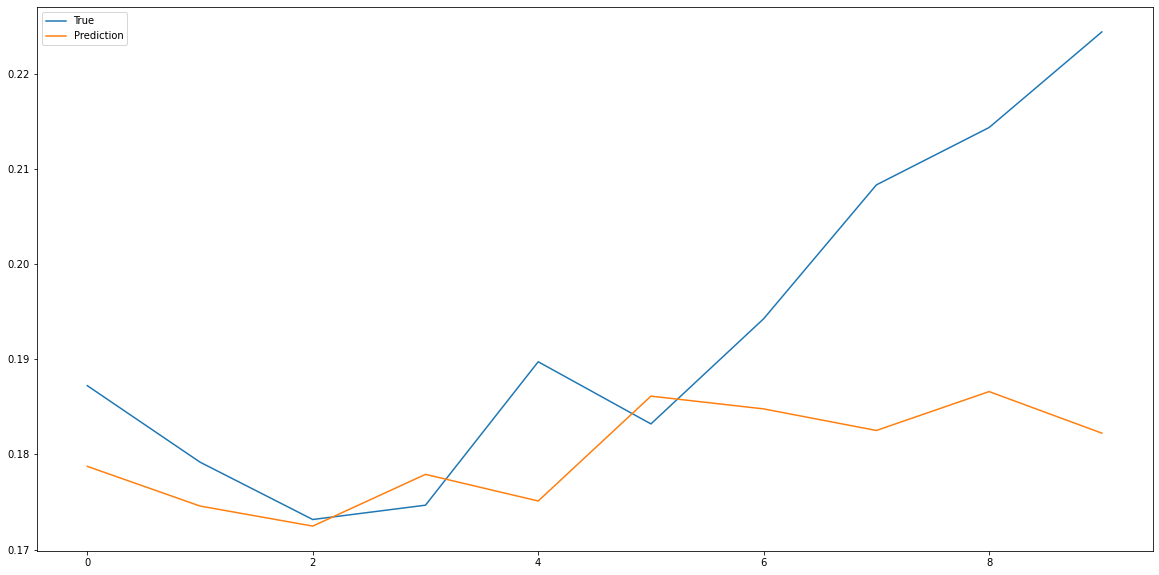

In [63]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test_, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

## 100 -> 5 Val loss = 0.0007 Epoch = 300 accuracy = 70%

In [52]:
print(pred)

[[0.1787484 ]
 [0.17457569]
 [0.17246799]
 [0.17790619]
 [0.17510667]
 [0.18613231]
 [0.18479025]
 [0.18252158]
 [0.18661103]
 [0.18224074]]


In [53]:
counter_normalize = (pred * (max_price + min_price)) + min_price
print(counter_normalize)

[[55005.996]
 [54590.914]
 [54381.254]
 [54922.22 ]
 [54643.734]
 [55740.51 ]
 [55607.008]
 [55381.336]
 [55788.133]
 [55353.4  ]]


In [54]:
!pip install openpyxl

In [55]:
for data in counter_normalize:
    print(data[0])

55005.996
54590.914
54381.254
54922.22
54643.734
55740.51
55607.008
55381.336
55788.133
55353.4


In [56]:
from openpyxl import Workbook

wb = Workbook()
ws1 = wb.active
ws1.title = "lstm_predicted_data"
ws1.append(["예측 가격"])

for data in counter_normalize:
    ws1.append([data[0]])

In [59]:
wb.save(filename='articles.xlsx')

In [ ]:
for index in range(2):
    print(index)